# MNIST Classification with Gradient Descent

#### by Vrinda Chauhan

## Python libraries

We will use the following libraries to analyze this dataset:
-  pandas: dataframe data structure based on the the naive R data structure. Some advantages of using this library is that it utilizes vectorized processes for fast manipulation of the data. In terms of memory usage, however, pandas is much less efficient; its advantage lies in computations for datasets larger than 500,000 rows
- numpy: python library that allows us to perform various mathematical operationss, especially for constructing and working with multidimensional arrays. numpy is better for memory usage for datasets smaller than 50,000 rows, and it allows use to use list comprehension instead of loops for our operations. 
- matplotlib: 2d plotting tools.
- IPython.display: displays the dataframes in a clean way
- time: allows us to calculate the speed of the different algorithms

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, HTML
from time import time
%matplotlib inline

## Discussion of the dataset

The MNIST dataset is a dataset of handwritten digits and their corresponding pixels. The data is split into two different dataframes, one of the training data and one of the test data. 

The first column of each data record is the label of the handwritten digit, a number from 0-9. The rest of the data record consists of the values of the pixels of the digit, a number between 0 and 255. This segment is a vector $x_{i} \in R^{784}$, which are concatinated from an image of $28x28$ pixels of the given digit.

Let's see what this looks like. 

In [2]:
train = pd.read_csv('./mnist_train.csv', header = None)

In [3]:
test = pd.read_csv('./mnist_test.csv', header = None)

In [4]:
print('The size of the training data is ',train.shape)
print('The size of the test data is ',test.shape)

The size of the training data is  (60000, 785)
The size of the test data is  (10000, 785)


In [5]:
display(HTML(train.head(15).to_html()))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,18,18,18,126,136,175,26,166,255,247,127,0,0,0,0,0,0,0,0,0,0,0,0,30,36,94,154,170,253,253,253,253,253,225,172,253,242,195,64,0,0,0,0,0,0,0,0,0,0,0,49,238,253,253,253,253,253,253,253,253,251,93,82,82,56,39,0,0,0,0,0,0,0,0,0,0,0,0,18,219,253,253,253,253,253,198,182,247,241,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,80,156,107,253,253,205,11,0,43,154,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,1,154,253,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,139,253,190,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,190,253,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,241,225,160,108,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,81,240,253,253,119,2

In [6]:
display(HTML(test.head(15).to_html()))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,84,185,159,151,60,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,222,254,254,254,254,241,198,198,198,198,198,198,198,198,170,52,0,0,0,0,0,0,0,0,0,0,0,0,67,114,72,114,163,227,254,225,254,254,254,250,229,254,254,140,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,66,14,67,67,67,59,21,236,254,106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,83,253,209,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,233,255,83,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,129,254,238,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59,249,254,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Note the data will be normalized, ie divided by 255 so that each pixel entry will be a real number in $[0,1]$; this is mainly to simplify the mathematical calculations in the gradient or loss, for example.

### Visualizing MNIST Digits

We mentioned earlier that each data record has a label and a concatinated pixel vector. Let's try to visualize what a randomly chosen digit from the training set will look like for each digit. To do this, we can define the following helper function:

In [7]:
def visualize(df, i):
    #This method takes in a dataframe and a desired digit, and outputs a plot with the digit and the index, chosen randomly
    a = df[df.columns[0]]
    label = list((float(i) for i in (a)))
    # n is our on and off switch for the while loop
    n = 0
    # the while loop picks a randomly indexed data record chosen by the np.random.choice method and compares its label 
    # to our desired i; if it is our desired digit then we engage in plotting it. If not, we keep remain engaged in the
    # while loop to keep picking random indexes
    while (n == 0):
        a_choice = np.random.choice(range(n, len(label)))
        if i == label[a_choice]:
            a_pixels = df.loc[a_choice]
            a_pixels = np.array(a_pixels[1:], dtype='uint8')
            a_pixels = a_pixels.reshape((28, 28))
            plt.imshow(a_pixels, cmap='gray')
            plt.title('Label is {i}, Index is {a_choice}'.format(i=i, a_choice=a_choice))
            plt.show()
            n=1
        else:
            n = 0


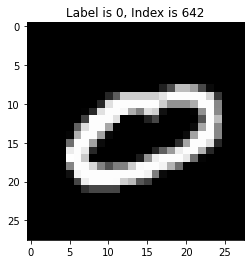

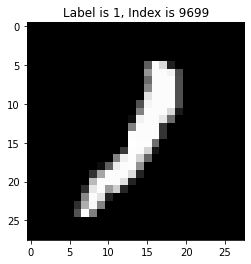

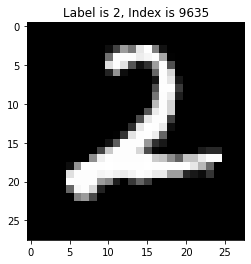

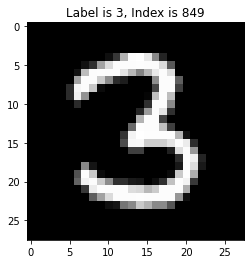

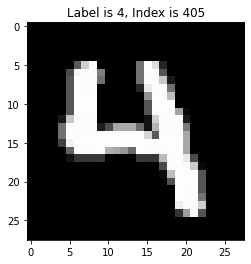

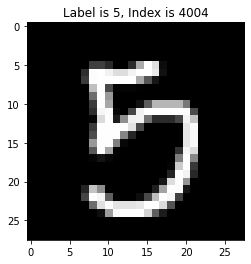

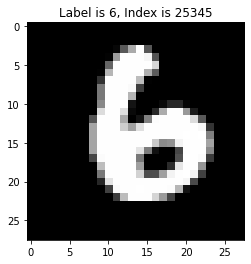

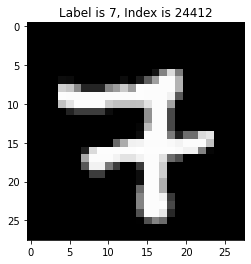

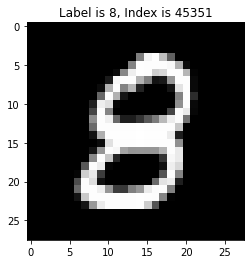

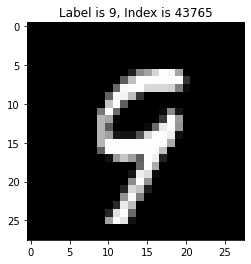

In [8]:
visualize(test,0)
visualize(test,1)
visualize(test,2)
visualize(test,3)
visualize(test,4)
visualize(train,5)
visualize(train,6)
visualize(train,7)
visualize(train,8)
visualize(train,9)

## Discussion of the problem

With this dataset, we want to solve a classification problem using discriminant analysis. We want to use the training sample to find a vector such that when we take the cross product of a data record's pixel segment and the weight vector, we can predict which digit the pixels represent be between two given digits (we correspond each of these digits with 1, -1 to make this calculation and function easier). In mathematical terms, we want $w$ such that $$ y_{i} = sign(w^{T}x_{i}) $$ where y is the label for the $i^{th}$ data record and the $x_{i}$ is the vector of pixels for that digit. Intuitively, what we are looking for the best fitting hyperplane that serperates the class of one digit's pixels from the class of the other digit's pixels. This will allow us to have a vector that makes predictions for the test data. With this, we can better understand the performance of each model. We will use the gradient descent algorithm and its variations to solve this problem.

## Discussion of the various Gradient Descent Methods

### Discussion of the loss function and some probability

In order to understand the gradient descent algorithm, we must first understand the distribution of the dataset, and the loss function affiliated with it. A loss function calculates the error rate for the classification. Our goal is to minimize this loss function.

In the MNIST dataset, we will be using a loss function called cross-entropy loss, which we will derive below. 

It can be shown the cumilitive distribution function of $G_{z}(z) = \frac{1}{1+e^{-z}} $ can model the probability of a given digit being the correct class label, if we affiliate our labels with a -1 and 1 (for example, if our model was meant to decide if a set of pixels is a 4 or 9, we could affiliate 4 with the "1" value and 9 with the "-1" value). 

Consider the random variable $y  := sign(\alpha + z)$ for $z$ as with the CDF, $\alpha$ fixed (we will discuss shortly how $\alpha$ is chosen). To see that  $G_{z}(z)$ is works here as a CDF, we can write $P(y= 1)$ and $P(y= -1)$ in terms of the CDF (one can easily verify that $G_{z}(z)$ is a valid CDF). $P(y=1)$ can be rewritten as $P(z > - \alpha)$ since $y=1$ when $\alpha + z > 0$ or $z > -\alpha$. Thus, we can use the CDF to solve this, by writing  $$P(y=1) = P(z > - \alpha) = 1-G_{z}(-a) = 1- \frac{1}{1+e^{-(-\alpha)}} = 1 - \frac{1}{1+e^{\alpha}}= \frac{e^{\alpha}}{1+e^{\alpha}}= \frac{1}{1+e^{-\alpha}} $$

Similarly, for  $P(y=-1)$, we evaluate  $P(z < -a)$ since $y<0$ when $\alpha + z < 0$, or $z < -\alpha$. Thus we can write $$P(y = -1) = P(z < -\alpha) = G_Z(-a)= \frac{1}{1+e^{\alpha}}$$

From this, it is plain to see what the probability mass function for y is $P(y) = \frac{1}{1+e^{-\alpha y}} $, and for multiple $y$'s that are independent and identically distributed (as we have with the labels for MNIST data) we can write this as $P(y) = \prod_{i=1}^{N} \frac{1}{1+e^{-\alpha_{i} y_{i}}} $ for a fixed set of $\alpha_{i}'s$. 

Now that we have done some groundwork for our loss function, we can discuss how $\alpha_{i}'s$ are chosen. In our MNIST dataset, if we set $\alpha_{i} = w^{T}x_{i}$ for $x_{i}$ being the pixel vector for the $i^{th}$ data record, we can solve our classification problem by maximizing the resulting function. This function would look like $$H(w) = \prod_{i=1}^{N} \frac{1}{1+e^{-w^{T}x_{i} y_{i}}} $$. 

So why does maximizing $H(w)$ solve our problem? We want to maximize $H(w)$ because this will give us the probability that the parities of $w^Tx_i$ and $y_i$ match. Indeed if the parities differ, then $w^{T}x_{i} y_{i}$ would be a negative expression, which would cancel with the negative inside the function, so  $H(w)$ would simplify to $\frac{1}{1+e^{w^T x_i y_i}}$, which makes $e^{w^T x_i y_i}$ large, and the overall expression very small. Note that when the parities of  $w^Tx_i$ and $y_i$ differ, the weight vector is not correctly classifying the digit. For example, perhaps we have the label of a digit be 9, which can correspond to -1. Recall we want $y_{i}= sign(w^{T} x_{i})$, so if the sign of $w^{T} x_{i}$ is 1, we know our weight vector is not correctly "predicting" the label. Thus our problem becomes $$ \max_{w} \prod_{i=1}^{N} \frac{1}{1+e^{-w^{T}x_{i} y_{i}}} $$

Now, this is equivalent to the problem $\max_{w} \sum_{i=1}^{N} log \biggl(\frac{1}{1+e^{-w^{T}x_{i} y_{i}}}\biggr)$, and log makes the calculations a bit easier to work with, so we want to apply it. Now, note that $\max_{w} \sum_{i=1}^{N} log \biggl(\frac{1}{1+e^{-w^{T}x_{i} y_{i}}}\biggr)$ is the same as minimizing $ 1 - \sum_{i=1}^{N} log \biggl(\frac{1}{1+e^{-w^{T}x_{i} y_{i}}}\biggr)$, which simplifies to  $\frac{1}{N}  \sum_{i=1}^{N} log(1+e^{-w^{T}x_{i} y_{i}})$. Thus, our primal optimization problem becomes $$ \min_{w} \frac{1}{N}  \sum_{i=1}^{N} log(1+e^{-w^{T}x_{i} y_{i}})$$ To solve this optimization problem, we will use gradient descent and its variations.


### What is gradient descent?

Gradient descent (GD) is a popular algorithm used in data science when solving classification problems. GD uses datapoints and the loss function, derived from the data distribution  to find a set of weights that, when applied to the datapoints, or data records, classify them into their label. In the MNIST dataset, this is useful because we are attepting to solve a classification problem: we are given training data of handwritten digits, and we want to find a weight vector that best classifies each data record to the label of the digit between two distinct digits. In mathematical terms, this means we want a weight vector so that the following equation holds for the correct label $l$ corresponding to each data record $x_{i}$, $$ w^{T}x_{i} = l$$ where $ l = [-1,1] $.
To obtain this weight vector, we want to find a $w$ such that the loss is at its minimum, ie as its gradient approaches 0. Thus, we want to head in the direction of the negative gradient until we get close to 0, and thus approach a minimum for the loss fuction. We update the weight vector iteratively until we reach a stopping criteria, which can be determined by passing a set threshold for the norm of the gradient or the loss function, for example. Thus the update steps for gradient descent look like: $$ w^{(t+1)} = w^{(t)} - \mu \nabla_{w}f$$ where $f$ is the loss function and $\mu$ denotes the learning rate, which can be determined in a number of different ways, and which is further explored in the different variations of gradient descent. With no variations, we take $\mu$ to be a scalar constant, determined through trial and error, but in some the variations, the learning rate is updated iteratively, allowing it to be a function of the other variables. 

The gradient of the loss function is $$\nabla_{w}f(w)= \frac{1}{N}  \sum_{i=1}^{N} \frac{- x_{i} y_{i}}{1+e^{w^{T}x_{i} y_{i}}}$$

#### Gradient Descent Demo

Let's go through a demo of gradient descent. To do this, we need to convert the file to a numpy array and define some helper methods.

In [9]:
train = (train.to_numpy())
test = (test.to_numpy())

This method takes in a dataset, a label scalar value, and a scalar parameter for the number of samples desired; it is meant to subset the dataset by a dataset of the desired label of a specific sample size

In [10]:
def select_digits(dataset, label, num_samples):
    indicator = dataset[:, 0] == label
    subsampled_dataset = dataset[indicator, :]
    subsampled_dataset = subsampled_dataset[0:num_samples, :]
    return subsampled_dataset

This is a function that takes in four parameters: a dataset, a set of two labels of the digits (the two we will compare in GD), a number of samples (which will be passed into the select_digits function), and a method of split vs none. The reason we define this method is so that we can split the data if required, or simply relabel it and keep it as one dataset

In [11]:
def process_data(dataset, class_labels, num_samples, method):
    dataset0 = select_digits(dataset, class_labels[0], num_samples)
    dataset1 = select_digits(dataset, class_labels[1], num_samples)
    dataset0[:, 0] = -1
    dataset1[:, 0] = 1
    dataset01 = np.concatenate((dataset0, dataset1), axis=0)
    if method == 'split':
        y = dataset01[:, 0]
        X = dataset01[:, 1:]
        return (X, y)
    else:
        return dataset01

This method calculates the loss function which we derived above.

In [12]:
def loss(w, df):
    lbl = df[:, 0]
    df = (df[:, 1:])/255
    summands =  np.array([(1 + np.exp(-w.T @ x * k)) for (x, k) in zip(df, lbl)])
    return np.log(np.mean(summands)) 

In [ ]:
This method calculates the gradient for loss function above.

In [13]:
def gradient(w, df):
    N = df.shape[0]
    lbl = df[:, 0]
    df = (df[:, 1:])/255
    summands = -1/N * np.array([y*x/(1 + np.exp(w.T@x * y)) for (x,y) in zip(df,lbl)])
    return np.sum(summands, axis=0)

This method is the GD algorithm itself, it performs the update steps for the weights, calculates the loss, etc. The stopping criteria we chose here is when the gradient approaches 0 and becomes less than the tol parameter, which is a sort of threshold we can set for the gradient to be considered "close enough" to 0. For variants of GD, we will define new functions in place of this one to see the demos, but our other helper functions will remain the same.

In [14]:
def GD(w_init, learning_rate, X, tol):
    c=0
    loss_vals = []
    m = learning_rate
    err = tol +1
    w = w_init
    
    while (err > tol) and (c<1500):
        p = gradient(w,X)
        w -= p*m
        h = loss(w, X)
        loss_vals.append(h)
        c +=1
        err = np.linalg.norm(p)
    return loss_vals, w

This method simply helps us plot the loss.

In [15]:
def plotloss(list, title):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.plot(list, '-o')
    ax.set_xlabel("Iteration", fontsize=20)
    ax.set_ylabel("Loss", fontsize=20)
    ax.set_title(title , fontsize=28)


In [16]:
def classify(weight_vector):
    X_test, y_test = process_data(test, class_labels=[1, 0], num_samples=500, method= 'split')
    y_train = train_sample[:, 0]
    X_train = train_sample[:, 1:]

    train_labels = np.sign(weight_vector.T @ X_train.T)
    test_labels = np.sign(weight_vector @ X_test.T)

    train_accuracy = np.sum(train_labels == y_train)/1000
    test_accuracy = np.sum(test_labels == y_test)/1000
    return train_accuracy, test_accuracy

In [17]:
train_sample = process_data(train, class_labels=[1, 0], num_samples=500, method = None)
tic = time()
v = np.ones(train_sample.shape[1]-1)
gd_loss_list, gd_weights = GD(w_init = v, learning_rate = 10e-2, X= train_sample ,tol = 10e-6)
toc = time()
print(f" Gradient Descent runtime: {toc-tic:.2f} seconds.")

 Gradient Descent runtime: 87.25 seconds.


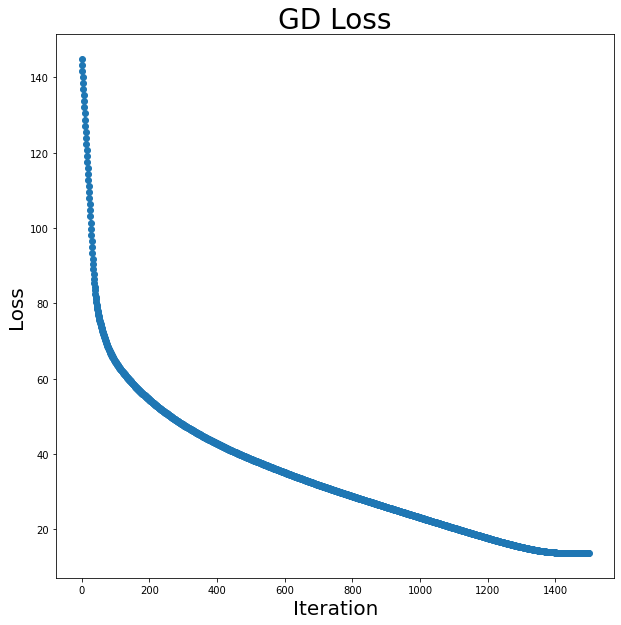

In [18]:
plotloss(gd_loss_list, title = 'GD Loss')

In [19]:
train_accuracy, test_accuracy = classify(gd_weights)
print('The accuracy rate for the training data is: ', train_accuracy)
print('The accuracy rate for the test data is: ', test_accuracy)

The accuracy rate for the training data is:  0.996
The accuracy rate for the test data is:  0.998


#### Gradient descent with momentum

Gradient descent with momentum, or Polyak momentum, is a variant of GD that uses the same basic idea of the GD, but gets a little more precise by incentivizing the algorithm to move further in the direction of the negative gradient if the previous iterate was also moving in that direction, and take shorter steps in the wrong direction (ie where the loss increases) by penalizing those steps where the direction of the gradient and the previous step don't match. It does this by adding a "momentum" term, so the update steps look like: $$ w^{(t+1)} = w^{(t)} - \mu \nabla_{w}f + \beta (w^{t} - w^{t-1})$$
Here, $\beta$ is chosen in a similar manner to the learning rate $\mu$; in the demo, we will limit our methods to trial and error for $\beta$. However, a more 

###### Gradient descent with classical momentum demo


We will use the following function for GD with momentum; this function is similar to the GD function we had, but we will include a momentum term to see how it compares to vanilla GD.

In [20]:
def GD_momentum(w_init, learning_rate, beta, X, tol):
    c=0
    loss_vals = []
    m = learning_rate
    err = tol +1
    w = w_init
    b=beta           
    temp = w.copy()

    
    while (err > tol) and (c<1500):
        
        p = gradient(w,X)
        
        if c >0:
            w_prev = temp.copy()
            temp = w.copy()
            w += -p*m + b*(w-w_prev)
  
        else:
            w -= p*m

        h = loss(w, X)
        loss_vals.append(h)

        c +=1
        err = np.linalg.norm(p)
    return loss_vals, w

In [21]:
tic = time()
v = np.ones(train_sample.shape[1]-1)
gdm_loss_list, gdm_weights = GD_momentum(w_init = v, learning_rate = 10e-2, beta = 0.9, X= train_sample ,tol = 10e-6)
toc = time()
print(f" GD with momentum runtime: {toc-tic:.2f} seconds.")

 GD with momentum runtime: 80.52 seconds.


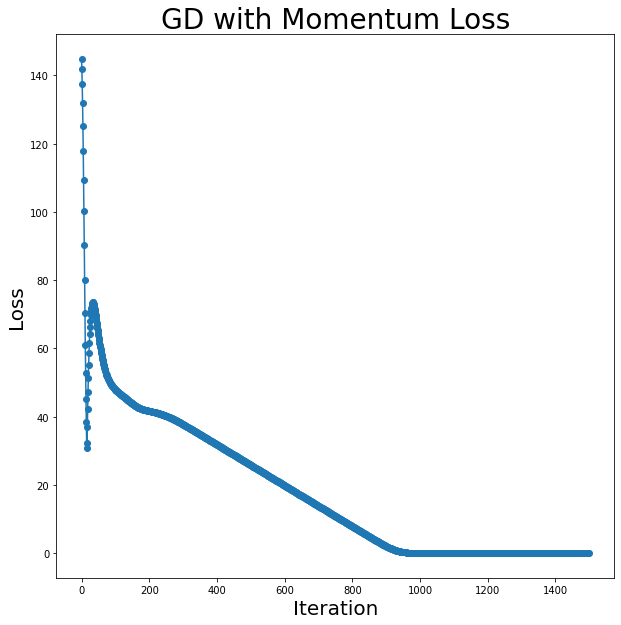

In [22]:
plotloss(gdm_loss_list, title = 'GD with Momentum Loss')

In [23]:
train_accuracy, test_accuracy = classify(gdm_weights)
print('The accuracy rate for the training data is: ', train_accuracy)
print('The accuracy rate for the test data is: ', test_accuracy)

The accuracy rate for the training data is:  1.0
The accuracy rate for the test data is:  0.999


Note the accuracy on both the training and the test data is higher with momentum. We will now explore a variant of GD with momentum, called Nesterov's Acceleration Gradient (also called NAG). It is similar to GD with momentum, but it performs the algorithm in two update steps:
1. First, we take a step in the "momentum direction", the direction of the previous two steps. 
2. Next, we take a gradient descent step from the momentum step, ie toward the direction of the negative gradient. 


By doimg this, the algorithm includes a penalty term in the gradient as well if the previous two steps were not in the same direction (unlike momentum, which only included this penalty with the overall algorithm). In mathematical terms, we need to define a new variable $y^{(t)}$ and update as follows:

$$ y^{(t)} = w^{(t)} + \beta (w^{(t)} - w^{(t-1)})$$

$$ w^{(t+1)} = y^{(t)} - \mu \nabla f(y^{(t)})$$
We can combine these to get: 
$$ w^{(t+1)} = w^{(t)} + \beta (w^{(t)} - w^{(t-1)}) - \mu \nabla f(w^{(t)} + \beta (w^{(t)} - w^{(t-1)}))$$


###### Nesterov's Acceleration Gradient demo


In [26]:
def NAG(w_init, learning_rate, beta, X, tol):
    c=0
    loss_vals = []
    m = learning_rate
    err = tol +1
    w = w_init
    b=beta           
    temp = w.copy()

    
    while (err > tol) and (c<1500):        
        if c >0:
            w_prev = temp.copy()
            temp = w.copy()
            y = w + b*(w-w_prev)
            w = y - m*gradient(y,X)
  
        else:
            w -= m*gradient(w,X)

        h = loss(w, X)
        loss_vals.append(h)
        err = np.linalg.norm(h)

        c +=1
    return loss_vals, w

In [27]:
tic = time()
v = np.ones(train_sample.shape[1]-1)
nag_loss_list, nag_weights = NAG(w_init = v, learning_rate = 10e-2, beta = 0.9, X= train_sample ,tol = 10e-6)
toc = time()
print(f" Nesterovs Accelerated Gradient runtime: {toc-tic:.2f} seconds.")

 Nesterovs Accelerated Gradient runtime: 77.99 seconds.


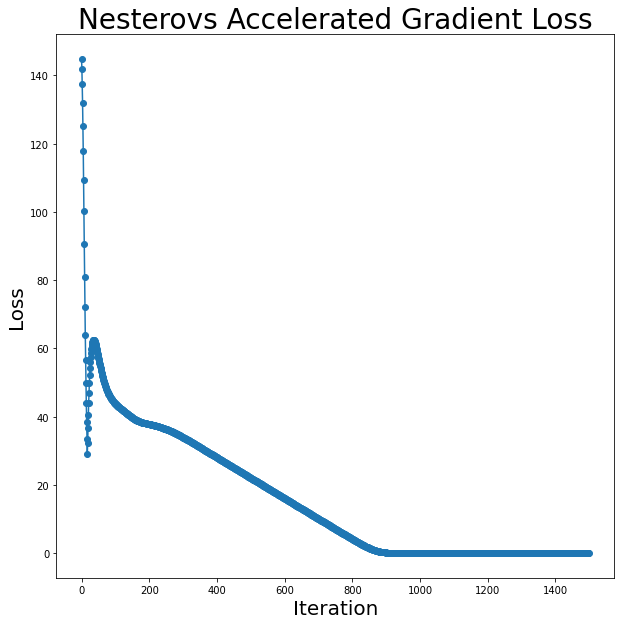

In [28]:
plotloss(nag_loss_list, title = 'Nesterovs Accelerated Gradient Loss')

In [29]:
train_accuracy, test_accuracy = classify(nag_weights)
print('The accuracy rate for the training data is: ', train_accuracy)
print('The accuracy rate for the test data is: ', test_accuracy)

The accuracy rate for the training data is:  1.0
The accuracy rate for the test data is:  0.998


#### Conjugate Gradient Descent

In [ ]:
def descent(X, tol, method = None):
    c=0
    N = X.shape[1] -1
    loss_vals = []
    feas = []
    
    if method not in ['SGD', 'gradient descent', 'CGD', 'ADMM', 'dual ascent' , '']:
        print('Error: invalid method')
    
    
    #initialize the rho, lambda, nu, and error
    rho = 0.002
    l = 2
    err = 5
    mu = 10e-4
    
    #initialize: weights, z, multiplier
    z = np.random.rand(1,N)
    w = np.ones((1,N))
    nu = np.random.rand(1,N)

    while (err > tol) and (c<1500) :
        random_index = np.random.choice(N, size=1, replace=True)
        dp_rand = X[random_index, :]
        y = dp_rand[0,0]
        x = ((dp_rand[:, 1:]) * y)/225 
        p = stochastic_gradient(w, x) + nu + (rho*(w-z))   

        
        #update weight
        w -= mu*p
        
        
        #the z update step
        z = (nu + rho*w)/(l + rho)
        
        
        #the Lagrangian multiplier update step
        nu += rho*(z-w)
        

        
        #calculate the loss, add it to the list
        h = loss(w, X, l)
        


        loss_vals.append(h)
        
        #calculate the feasibility, add it to the list
        j =np.linalg.norm(z-w)
        
        feas.append(j)
        
        
        if c > 0:
            if ((np.linalg.norm(p))<10e-7):
                err = np.linalg.norm(p_prev - p)
        
        
        p_prev = p
        
        mu = (1/((c+1)**0.5))*mu
        
        rho = 0.5*rho
        c+=1

    return w, loss_vals, feas, c

In [ ]:
def stochastic_gradient(w, x_i):
    return (x_i) / (1 + np.exp(np.dot(w, x_i.T)))

In [ ]:
train_sample = split_data(train, class_labels=[1, 0], num_samples=500, method = None)
tic = time()
weights, loss_list, feas_list,itrs = ADMM(train_sample, tol = 10e-6, method = 'ADMM')
toc = time()
print(f" runtime: {toc-tic:.2f} seconds.")

In [58]:
thislist = []
for i in range(len(gd_loss_list)):
    if gd_loss_list[i] == gdm_loss_list[i]:
        thislist.append( gd_loss_list[i])
    else: print('yo')
print(len(gd_loss_list))

1500
